## Matmul

why do we care?

> While in today’s computer chips, multiplication takes about the same number of cycles as addition

Wait. In that case, why do we care?
Same number of cycles, isnt the same as having the same computational cost!?


* http://www.theoryofcomputing.org/articles/gs005/gs005.pdf
* https://en.wikipedia.org/wiki/Bilinear_map
* https://arxiv.org/abs/1011.1350

In [1]:
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# want to convert this into fast numerical code using cuda or similar!! -- http://cython.org/
# count how many times we mul
# would be cooler to overload multiplication?

In [3]:
def counted(fn):  # not quite idea, want it to reset after every top level call
    def wrapper(*args, **kwargs):
        wrapper.called += 1
        return fn(*args, **kwargs)
    wrapper.called = 0
    wrapper.__name__ = fn.__name__
    return wrapper

def split(matrix):  # split matrix into quarters
    row, col = matrix.shape
    m11 = matrix[:row//2, :col//2]  # top left
    m12 = matrix[:row//2, col//2:]  # top right
    m21 = matrix[row//2:, :col//2]  # bottom left
    m22 = matrix[row//2:, col//2:]  # bottom right
    return m11, m12, m21, m22

@counted
def strassen(a, b):
    # base case: 1x1 matrix
    if len(a) == 1:  
        return a * b
    else:
        a11, a12, a21, a22 = split(a)
        b11, b12, b21, b22 = split(b)
        
        p1 = strassen(a11 + a22, b11 + b22)
        p2 = strassen(a21 + a22, b11)
        p3 = strassen(a11, b12 - b22)
        p4 = strassen(a22, - b11 + b21)
        p5 = strassen(a11 + a12, b22)
        p6 = strassen(- a11 + a21, b11 + b12)
        p7 = strassen(a12 - a22, b21 + b22)
        
        c11 = p1 + p4 - p5 + p7
        c12 = p3 + p5
        c21 = p2 + p4
        c22 = p1 - p2 + p3 + p6
        
        return np.vstack((np.hstack((c11, c12)), np.hstack((c21, c22)))) 

In [4]:
def test(shape):
    A = rnd.random(shape)
    B = rnd.random(shape)
    C = strassen(A, B)
    C_ = np.dot(A, B)
    assert np.sum(np.abs(C - C_)) < 1e-8
    
test((32, 32))

[0.00000e+00 0.00000e+00 5.70000e+01 4.00000e+02 2.80100e+03 1.96080e+04
 1.37257e+05 9.60800e+05]


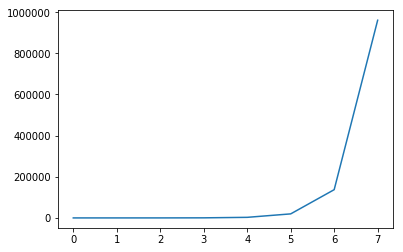

In [6]:
calls = np.zeros(8)
strassen.called = 0
for i in range(2, len(calls)):
#     print(2**i)
    test((2**i,2**i))
    calls[i] = strassen.called
    strassen.called = 0
    
plt.plot(range(8), calls)
# plt.plot(range(8))
print(calls)

In [7]:
def time(shape):
    A = rnd.random(shape)
    B = rnd.random(shape)
    %timeit C = strassen(A, B)
    %timeit C_ = np.dot(A, B)
time((16,16))

10.9 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.22 µs ± 15.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
# HA. that is slow...
# Also profile vanilla matmul.

A cool perspective that isnt the natural way to consider tensors.
The elements of my matrix, are matrices. This makes sense if we just think of the elements of a matrix as any ring/field.

__Wait, but why?!__ 

Why is strassen faster? What intution is there for where the algol comes from, seems rather unusual...

Simple, it uses less multiplications. Yes, but why is that possible?


### The matrix multiplication tensor

The matrix multiplication tensor for $n x n$ matrices is

$$
MM^{abc}_{def} = \delta^a_e \delta^b_f \delta^c_d
$$

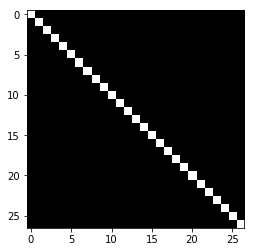

In [10]:

def MM_tensor(n): #BUT how does this related to x_shape and y_shape??
    # MM(a,b,c,d,e,f) = 1(ae)1(bf)1(cd)
    i, j, k = np.ogrid[:n, :n, :n]
    M = np.zeros((n,n,n,n,n,n))
    M[i, j, k, i, j, k] = 1
    return M

n = 3
M = MM_tensor(n)
plt.imshow(M.reshape((n**3,n**3)), cmap='gray')

In [11]:
np.rank(M)

/home/act65/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  """Entry point for launching an IPython kernel.


6

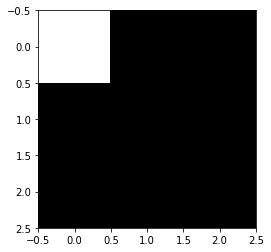

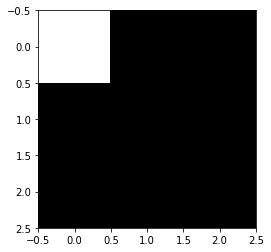

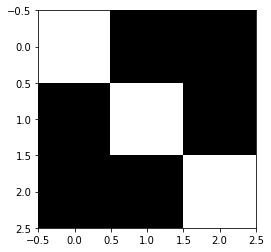

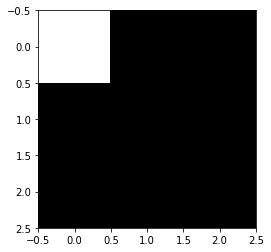

In [12]:
plt.figure()
plt.imshow(M[:,:,0,0,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,:,0,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,0,:,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,0,0,:,0].reshape((n,n)), cmap='gray')
## WANT a way to visualise this thing!

>  However, de Groote [dG78] has shown that all 7-term decompositions of MM 2 are equivalent up to a change of basis, i.e., an instance of the GL(n)3 action (2)

ok. 
* wtf is the MM-tensor. 
* why does the MM-tensor rank have anything to do with the number of multiplications required?
* what is so special about GL(n)3? What has it got to do with MM?
* can we visualise the MM-tensor as a tensor network?

## Strassens algol for tensor contraction

Can we generalise strassen in a non-trivial way to tensors?

Currently (cite) best algol just reshapes tensor (in an intellgient way?) into a matrix and applies vanilla strassens algol. https://github.com/flame/tblis-strassen

WANT - if strassens does a 2d partition on matrices, can we formulate a nd partition and decompose that? So (2x2x2) x (2x2x2) is the base case for 3 dim tensors?!?